In [19]:
from qiskit import QuantumCircuit, transpile
from qiskit.synthesis import synth_cnot_count_full_pmh
from ai_linear_function_synthesis import *
from qiskit.quantum_info import Operator
from qiskit.circuit.library import LinearFunction
from qiskit_aer import AerSimulator

from tqdm import tqdm
from stable_baselines3 import PPO


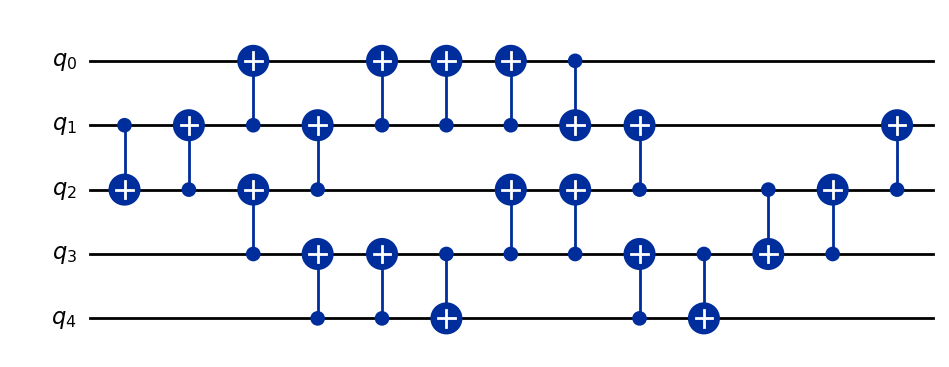

In [20]:
NUM_QUBITS = 5
COUPLING_MAP = CouplingMap.from_line(NUM_QUBITS)
BATCH_SIZE = 100
SUCCESS_RATE_THRESHOLD = 0.8

np.random.seed(10)

# get random circuit
qc = random_linear_function_circuit_by_difficulty(
    NUM_QUBITS,
    difficulty=20,
    coupling_map=COUPLING_MAP,
)
qc.draw("mpl")

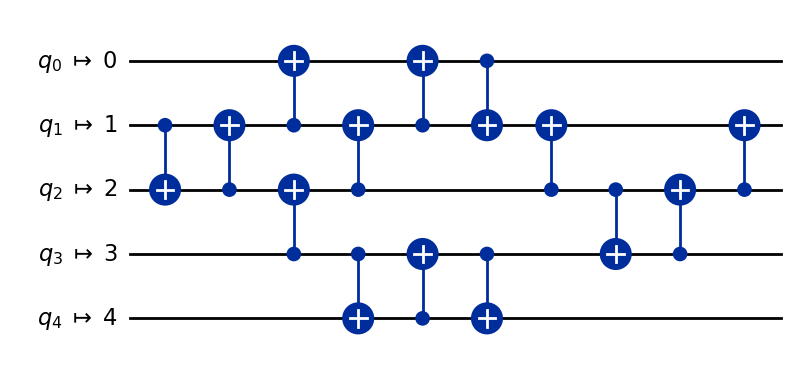

In [21]:
transpile(
    qc,
    optimization_level=3,
    basis_gates=["cx", "u3"],
    initial_layout=list(range(NUM_QUBITS)),
    seed_transpiler=42,
).draw("mpl")

In [22]:
binary_matrix = linear_function_circuit_to_binary_matrix(qc)
binary_matrix

array([[ True,  True,  True,  True, False],
       [ True,  True, False,  True,  True],
       [False, False, False, False,  True],
       [False,  True,  True,  True,  True],
       [False, False, False,  True, False]])

CNOT count by PMH synthesis: 28
CNOT depth by PMH synthesis: 24


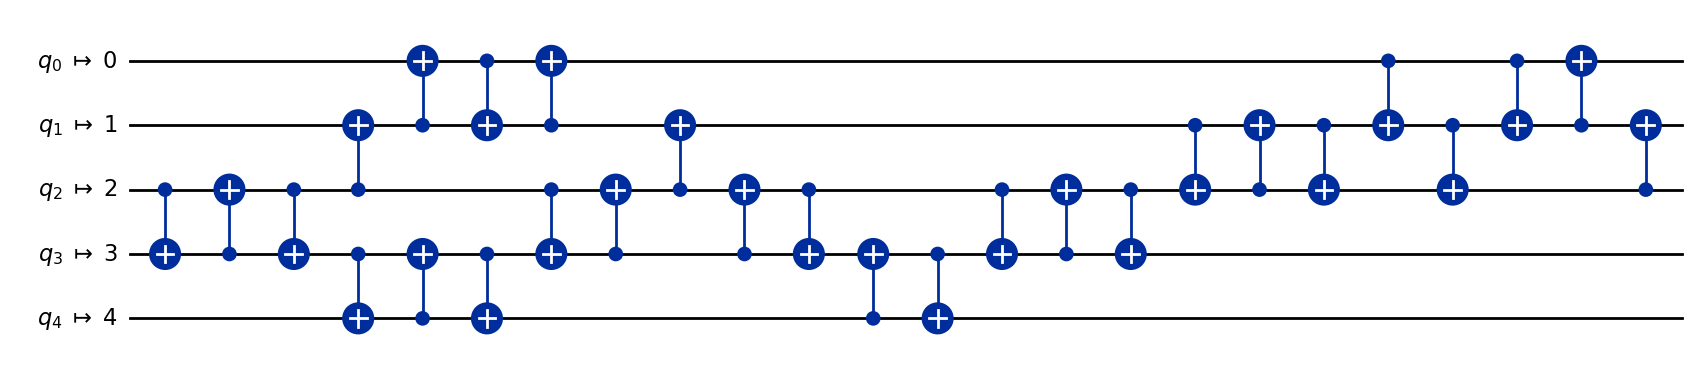

In [23]:
qc_qiskit = synth_cnot_count_full_pmh(binary_matrix)
qc_qiskit = transpile(
    qc_qiskit,
    coupling_map=COUPLING_MAP,
    optimization_level=3,
    basis_gates=["cx", "u3"],
    initial_layout=list(range(NUM_QUBITS)),
    seed_transpiler=42,
)
print(f"CNOT count by PMH synthesis: {qc_qiskit.count_ops().get('cx', 0)}")
print(f"CNOT depth by PMH synthesis: {qc_qiskit.depth()}")
qc_qiskit.draw("mpl")

In [24]:
qc_qiskit.layout.final_layout

Layout({
2: <Qubit register=(5, "q"), index=0>,
1: <Qubit register=(5, "q"), index=1>,
4: <Qubit register=(5, "q"), index=2>,
0: <Qubit register=(5, "q"), index=3>,
3: <Qubit register=(5, "q"), index=4>
})

In [25]:
# equivalence check

from qiskit.circuit.library import PermutationGate

np.testing.assert_allclose(
    Operator(qc_qiskit.compose(PermutationGate([2, 1, 4, 0, 3]), qc_qiskit.qubits)),
    Operator(qc),
)

In [26]:
model = PPO.load("saved_models/lin_func_curriculum")
env = AILinearFunctionSynthesis(
    coupling_map=COUPLING_MAP,
    eval_batch_size=BATCH_SIZE,
    success_rate_threshold=SUCCESS_RATE_THRESHOLD,
)

========== step 0 ==========
QuantumCircuit:
     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
state:
[[[ True  True  True  True False]
  [ True  True False  True  True]
  [False False False False  True]
  [False  True  True  True  True]
  [False False False  True False]]]
num_cnots: 0
truncated: False
terminated: False
========== step 1 ==========
action: 3, reward: -0.01, info: {'is_success': False}
QuantumCircuit:
          
q_0: ─────
     ┌───┐
q_1: ┤ X ├
     └─┬─┘
q_2: ──■──
          
q_3: ─────
          
q_4: ─────
          
state:
[[[ True  True  True  True False]
  [ True  True False  True False]
  [False False False False  True]
  [False  True  True  True  True]
  [False False False  True False]]]
num_cnots: 1
truncated: False
terminated: False
========== step 2 ==========
action: 5, reward: -0.02, info: {'is_success': False}
QuantumCircuit:
               
q_0: ──────────
     ┌───┐     
q_1: ┤ X ├─────
     └─┬─┘┌───┐
q_2: ──■──┤ X ├
          └─┬─┘
q_3:

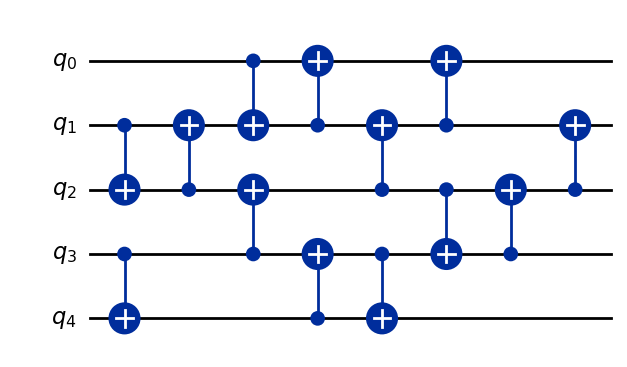

In [27]:
env.reset()
env.state = binary_matrix[np.newaxis, :, :].copy()
env.difficulty = None
step_count = 0

print(f"========== step {step_count} ==========")
env.render()

# after setting env.state manually, get the observation
obs = env._get_obs()

episode_over = False
while not episode_over:
    # Use the trained agent's policy (PPO) to select actions
    action, _states = model.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = env.step(int(action))
    step_count += 1

    print("truncated:", truncated)
    print("terminated:", terminated)
    episode_over = terminated or truncated

    print(f"========== step {step_count} ==========")
    print(f"action: {action}, reward: {reward}, info: {info}")
    qc_rl = env.render()

print(f"Episode finished. Total reward: {reward}, steps: {step_count}, success: {info.get('is_success', False)}")
qc_rl.inverse().draw("mpl")

In [28]:
qc_rl.inverse().depth()


8

In [29]:
# you need to invert the circuit to recover the original circuit
linear_function_circuit_to_binary_matrix(qc_rl.inverse())

np.testing.assert_allclose(Operator(qc_rl.inverse()), Operator(qc))